# QPSK SER 仿真

本 Notebook 重现了两个仿真：

- **No1.m**：比较 SISO、MRC 1x2 和 MRC 1x4 系统的符号错误率 (SER)。
- **No2.m**：比较 Alamouti STC 2x1（发射分集）与 MRC 1x2（接收分集）系统的 SER。

所有仿真均采用 QPSK 调制，并对信道使用瑞利衰落模型，噪声为复高斯噪声，最终利用 semilogy 绘制 SER 曲线。

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 为保证结果可重复（可选）
np.random.seed(0)

def qpsk_detection(x):
    """
    根据实部和虚部符号进行检测，并归一化
    """
    return (np.sign(np.real(x))/np.sqrt(2)) + 1j*(np.sign(np.imag(x))/np.sqrt(2))

def calculate_ser(x, x_detected):
    """
    计算符号错误率（误码数/总符号数）
    """
    errors = np.sum(np.abs(x - x_detected) > np.finfo(float).eps)
    return errors / x.size

print('导入库及定义辅助函数完成.')

导入库及定义辅助函数完成.


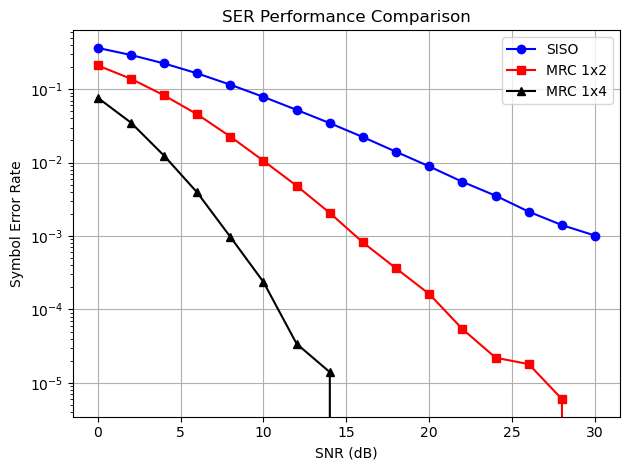

In [4]:
# --------------------- No1.m 仿真：SISO, MRC 1x2, MRC 1x4 ---------------------

# 参数设置
QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)  # QPSK 符号映射
SNRdB = np.arange(0, 32, 2)  # SNR 范围（dB）
SNR_linear = 10**(SNRdB/10)   # 线性 SNR
N = 500000  # 符号数

# 预分配存储
SER_SISO = np.zeros(len(SNRdB))
SER_MRC2 = np.zeros(len(SNRdB))
SER_MRC4 = np.zeros(len(SNRdB))

for idx, snr in enumerate(SNR_linear):
    rho = 1/np.sqrt(snr)  # 噪声缩放因子
    
    # 生成发射信号
    tx_symbols = np.random.choice(QPSK_vec, size=N)
    
    # ----- SISO 仿真 -----
    h_SISO = (np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2)  # 瑞利信道
    noise_SISO = rho * ((np.random.randn(N) + 1j*np.random.randn(N)) / np.sqrt(2))  # 复高斯噪声
    
    rx_SISO = h_SISO * tx_symbols + noise_SISO  # 接收信号
    eq_SISO = rx_SISO / h_SISO  # 迫零均衡
    dec_symbols_SISO = qpsk_detection(eq_SISO)
    SER_SISO[idx] = calculate_ser(tx_symbols, dec_symbols_SISO)
    
    # ----- MRC 1x2 仿真 -----
    Nr = 2
    h_MRC2 = (np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)) / np.sqrt(2)  # 2xN 信道矩阵
    noise_MRC2 = rho * ((np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)) / np.sqrt(2))
    
    # 接收信号（各天线独立）
    rx_MRC2 = h_MRC2 * tx_symbols[np.newaxis, :] + noise_MRC2
    
    # 最大比合并
    combined_signal = np.sum(np.conj(h_MRC2) * rx_MRC2, axis=0) / np.sum(np.abs(h_MRC2)**2, axis=0)
    dec_symbols_MRC2 = qpsk_detection(combined_signal)
    SER_MRC2[idx] = calculate_ser(tx_symbols, dec_symbols_MRC2)
    
    # ----- MRC 1x4 仿真 -----
    Nr = 4
    h_MRC4 = (np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)) / np.sqrt(2)  # 4xN 信道矩阵
    noise_MRC4 = rho * ((np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)) / np.sqrt(2))
    
    rx_MRC4 = h_MRC4 * tx_symbols[np.newaxis, :] + noise_MRC4
    combined_signal = np.sum(np.conj(h_MRC4) * rx_MRC4, axis=0) / np.sum(np.abs(h_MRC4)**2, axis=0)
    dec_symbols_MRC4 = qpsk_detection(combined_signal)
    SER_MRC4[idx] = calculate_ser(tx_symbols, dec_symbols_MRC4)

# 结果可视化
plt.figure()
plt.semilogy(SNRdB, SER_SISO, 'b-o', linewidth=1.5, label='SISO')
plt.semilogy(SNRdB, SER_MRC2, 'r-s', linewidth=1.5, label='MRC 1x2')
plt.semilogy(SNRdB, SER_MRC4, 'k-^', linewidth=1.5, label='MRC 1x4')
plt.grid(True)
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate')
plt.legend()
plt.title('SER Performance Comparison')
plt.tight_layout()
plt.show()

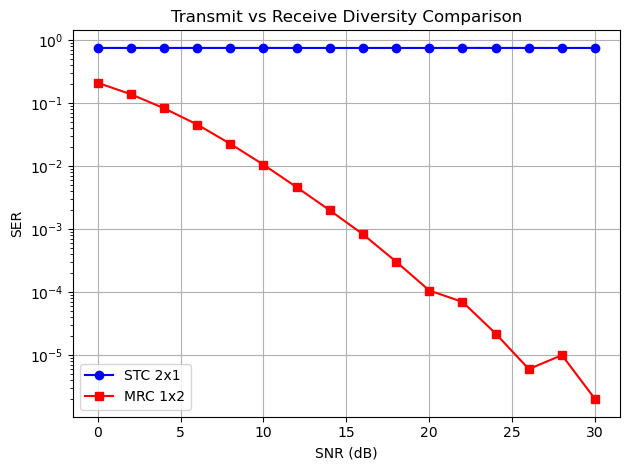

In [5]:
# --------------------- No2.m 仿真：Alamouti STC 2x1 与 MRC 1x2 ---------------------

# 参数设置
QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)  # QPSK 符号
SNRdB = np.arange(0, 32, 2)  # SNR 范围（dB）
SNR_linear = 10**(SNRdB/10)   # 线性 SNR
N = 500000  # 符号数（必须为偶数）

# 预分配存储
SER_STC21 = np.zeros(len(SNRdB))
SER_MRC12 = np.zeros(len(SNRdB))

for idx, snr in enumerate(SNR_linear):
    rho = 1/np.sqrt(snr)  # 噪声系数
    
    # 生成发射符号
    tx_symbols = np.random.choice(QPSK_vec, size=N)
    
    # ----- Alamouti STC 2x1 仿真 -----
    # 对符号重排为 2x(N/2) 的矩阵
    symbol_pairs = tx_symbols.reshape((2, -1))
    s0 = symbol_pairs[0, :] / np.sqrt(2)  # 每个天线功率归一化
    s1 = symbol_pairs[1, :] / np.sqrt(2)
    
    num_pairs = symbol_pairs.shape[1]
    # 信道建模
    h1 = (np.random.randn(num_pairs) + 1j*np.random.randn(num_pairs)) / np.sqrt(2)
    h2 = (np.random.randn(num_pairs) + 1j*np.random.randn(num_pairs)) / np.sqrt(2)
    
    # 噪声功率调整（方差 = rho^2）
    noise_power = rho**2
    noise0 = np.sqrt(noise_power/2) * (np.random.randn(num_pairs) + 1j*np.random.randn(num_pairs))
    noise1 = np.sqrt(noise_power/2) * (np.random.randn(num_pairs) + 1j*np.random.randn(num_pairs))
    
    # 接收信号
    y0 = h1 * s0 + h2 * s1 + noise0
    y1 = -h1 * np.conj(s1) + h2 * np.conj(s0) + noise1
    
    # Alamouti 解码（向量化实现）
    s_hat0 = np.conj(h1) * y0 + h2 * np.conj(y1)
    s_hat1 = np.conj(h2) * y0 - h1 * np.conj(y1)
    norm_factor = np.abs(h1)**2 + np.abs(h2)**2
    s_hat0 = s_hat0 / norm_factor
    s_hat1 = s_hat1 / norm_factor
    
    # 合并后拉平成列向量（按列展开，与 MATLAB 的 s_tilde(:) 相同）
    s_hat = np.vstack((s_hat0, s_hat1))
    s_hat = s_hat.flatten('F')
    
    # 符号检测
    dec_symbols_STC = qpsk_detection(s_hat)
    SER_STC21[idx] = calculate_ser(tx_symbols, dec_symbols_STC)
    
    # ----- MRC 1x2 仿真 -----
    Nr = 2
    h_MRC = (np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)) / np.sqrt(2)
    noise_MRC = rho * ((np.random.randn(Nr, N) + 1j*np.random.randn(Nr, N)) / np.sqrt(2))
    
    rx_MRC = h_MRC * tx_symbols[np.newaxis, :] + noise_MRC
    combined_signal = np.sum(np.conj(h_MRC) * rx_MRC, axis=0) / np.sum(np.abs(h_MRC)**2, axis=0)
    dec_symbols_MRC = qpsk_detection(combined_signal)
    SER_MRC12[idx] = calculate_ser(tx_symbols, dec_symbols_MRC)

# 结果可视化
plt.figure()
plt.semilogy(SNRdB, SER_STC21, 'b-o', linewidth=1.5, label='STC 2x1')
plt.semilogy(SNRdB, SER_MRC12, 'r-s', linewidth=1.5, label='MRC 1x2')
plt.grid(True)
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.legend()
plt.title('Transmit vs Receive Diversity Comparison')
plt.tight_layout()
plt.show()